In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate df 的每个特征，修改数据类型，降低内存占用 """
    # 初始 df 的内存占用, sum的结果是 B，除以两个1024，变成 MB
    start_mem = df.memory_usage().sum() / 1024 / 1024 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        # 对于非object的数值型特征，分别计算该特征的最小值和最大值所占内存的上下界
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # 如果是整型数据，从占用内存最小的数据类型开始，依次进行数值比较，测试 特征的取值范围 是否在 该数据类型的取值范围里
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) 
            # 如果是浮点型数据，同样是依次进行比较，但是最小的是float16，而且float32基本上已经足够大，够用了
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # 对于object型数据，转换为分类型数据，降低内存占用(没有时间型特征，只留了使用天数)
        else:
            df[col] = df[col].astype('category')
    
    # 修改每个特征的数据类型后，df 的内存占用
    end_mem = df.memory_usage().sum()  / 1024 / 1024 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
np.iinfo(np.int8)

iinfo(min=-128, max=127, dtype=int8)

In [5]:
np.iinfo(np.int8).min, np.iinfo(np.int8).max

(-128, 127)

In [6]:
np.finfo(np.float32)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [8]:
np.finfo(np.float16)

finfo(resolution=0.001, min=-6.55040e+04, max=6.55040e+04, dtype=float16)

In [3]:
data = reduce_mem_usage(pd.read_csv('data_for_tree.gz'))

Memory usage of dataframe is 59.22 MB
Memory usage after optimization is: 15.75 MB
Decreased by 73.4%


In [6]:
data.to_csv('data_for_tree1.gz')

In [16]:
data.shape

(199037, 39)

仍有部分特征是有缺失值的，notRepairedDamage的缺失值最容易被忽略

In [32]:
data.columns[data.isnull().any()]

Index(['bodyType', 'fuelType', 'gearbox', 'model', 'price', 'used_time',
       'city', 'power_bin'],
      dtype='object')

In [33]:
data.notRepairedDamage[:5]

0    0.0
1      -
2    0.0
3    0.0
4    0.0
Name: notRepairedDamage, dtype: category
Categories (3, object): [-, 0.0, 1.0]

In [4]:
continuous_features = [x for x in data.columns if x not in ['price','brand','model']]

**缺失值不能用0填充吧，有些特征的缺失值就是0呢？？**

### 一、线性回归 & 五折交叉验证 & 模拟真实业务情况

In [9]:
data.notRepairedDamage.value_counts()

0.0    147809
-       32251
1.0     18977
Name: notRepairedDamage, dtype: int64

In [14]:
b = data.notRepairedDamage.replace('-', 0).astype(np.float16)
b.astype(np.int8).value_counts()

0    180060
1     18977
Name: notRepairedDamage, dtype: int64

In [15]:
data.head(3)

,SaleID,bodyType,brand,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,...,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,0,1.0,6,0.0,0.0,12.5,30.0,736,0.0,0,...,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
1,1,2.0,1,0.0,0.0,15.0,40.0,2262,-,0,...,4756.0,4.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,NaN
2,2,1.0,15,0.0,0.0,12.5,115.0,14874,0.0,0,...,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0


In [19]:
data.dropna().index

Int64Index([     0,      2,      4,      5,      6,      7,      8,     10,
                11,     12,
            ...
            149025, 149026, 149027, 149028, 149029, 149031, 149032, 149033,
            149034, 149035],
           dtype='int64', length=91729)

In [5]:
# drop以后会删去所有的训练数据
data = data.dropna().reset_index(drop=True)
# 用notRepairedDamage特征值的众数替换缺失值，应该只有该特征有 -
# 根据该特征的取值，int8就可以了，但是只能将原来的字符型浮点数转换为浮点数，而不能转换为整数，但是float可以转换为整型
data['notRepairedDamage'] = data['notRepairedDamage'].replace('-', 0).astype(np.float16).astype(np.int8)

train_X = data[continuous_features]
train_y = data['price']

#### 1 简单建模 & 标签的正态分布

In [7]:
from sklearn.linear_model import LinearRegression
import time
start = time.time()
# l2正则化， 不加时也是0.18s 左右
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)
end = time.time()
print(end - start, 's')

0.18056178092956543 s


查看训练的线性回归模型的截距（intercept）与权重(coef)

In [26]:
print('intercept:'+ str(model.intercept_))
# 权重从大到小排序，字典的排序：按键值排
sorted(dict(zip(continuous_features, model.coef_)).items(), key=lambda x: x[1], reverse=True)

intercept:-110670.68277075786


[('v_6', 3367064.341641869),
 ('v_8', 700675.5609398916),
 ('v_9', 170630.2772322144),
 ('v_7', 32322.66193202752),
 ('v_12', 20473.670796962964),
 ('v_3', 17868.07954149201),
 ('v_11', 11474.938996740202),
 ('v_13', 11261.764560011892),
 ('v_10', 2683.9200905552707),
 ('gearbox', 881.8225039249025),
 ('fuelType', 363.90425072165164),
 ('bodyType', 189.60271012073065),
 ('city', 44.94975120522174),
 ('power', 28.553901616752594),
 ('brand_price_median', 0.5103728134078995),
 ('brand_price_std', 0.45036347092633167),
 ('brand_amount', 0.14881120395065975),
 ('brand_price_max', 0.0031910186703138377),
 ('SaleID', 5.35598991985751e-05),
 ('seller', 4.227447789162397e-06),
 ('offerType', 1.965701812878251e-06),
 ('train', -1.5418627299368382e-06),
 ('brand_price_sum', -2.1750068681876972e-05),
 ('name', -0.0002980012713042195),
 ('used_time', -0.0025158943328787604),
 ('brand_price_average', -0.40490484510115926),
 ('brand_price_min', -2.2467753486893227),
 ('power_bin', -34.42064411725974

In [8]:
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

In [9]:
subsample_index

array([ 2935, 85236,   423, 65532, 35025, 19128, 24593, 56624, 65381,
       37612, 43085, 85756, 36780, 87135, 26508, 82274, 53027, 25057,
       11802, 12850, 45775, 42446, 43067, 18036, 59371, 47116, 72612,
        7620, 57922, 24700, 78801, 63374, 58348, 72164, 16508, 82836,
       61343, 40951,  7487,  9629, 28937, 31666, 40871, 34108, 61987,
        5501, 11278,  4314, 80833, 55712])

绘制特征v_9的值（为何单独用这个特征？？）与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明模型存在一些问题

**以前在做机器学习的回归模型时，都忘了正态性假定了，也很少有教材会提，自己也没有注意**

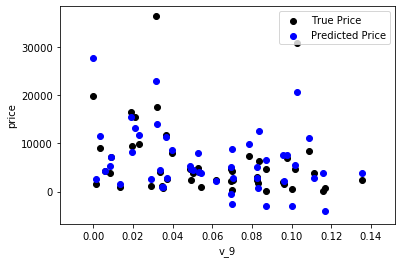

In [10]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'], loc='upper right')
# print('The predicted price is obvious different from true price')
plt.show()

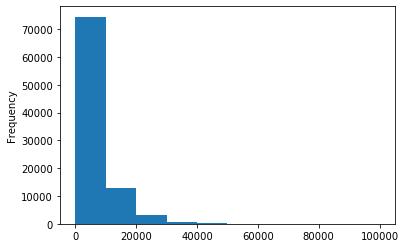

In [11]:
train_y.plot.hist()

In [12]:
train_y.min()

13.0

pandas作图太粗糙了，bins分的不够细

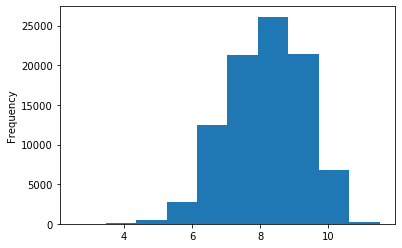

In [13]:
# 最小值大于0，取对数时可以不加1
np.log(train_y).plot.hist()

通过作图发现预测目标呈现长尾分布，不利于我们的建模预测。原因是很多模型都**假设数据误差项符合正态分布**，而长尾分布的数据违背了这一假设。

In [32]:
np.quantile(train_y, 0.9), np.quantile(train_y, 0.5), train_y.median(), np.quantile(train_y, 1), train_y.max()

(14900.0, 3800.0, 3800.0, 99999.0, 99999.0)

In [34]:
train_y.shape, train_y[train_y < np.quantile(train_y, 0.9)].shape

((91729,), (82437,))

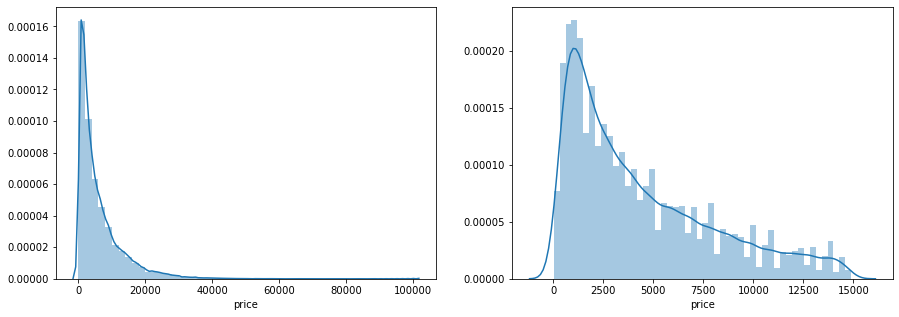

In [14]:
import seaborn as sns
# print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))

# 典型的指数分布
plt.subplot(1,2,1)
sns.distplot(train_y)

# series的bool过滤，去掉尾部数据，但是数据也变小了，而且是否适合测试集呢，如果测试集也存在取值较大的情况，大的异常值造成的预测偏差就会过大了
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)]) # 90%分位数

对标签进行了**log(x+1)变换**，使标签贴近于正态分布，注意要加 1

In [15]:
train_y_log = np.log(train_y + 1)

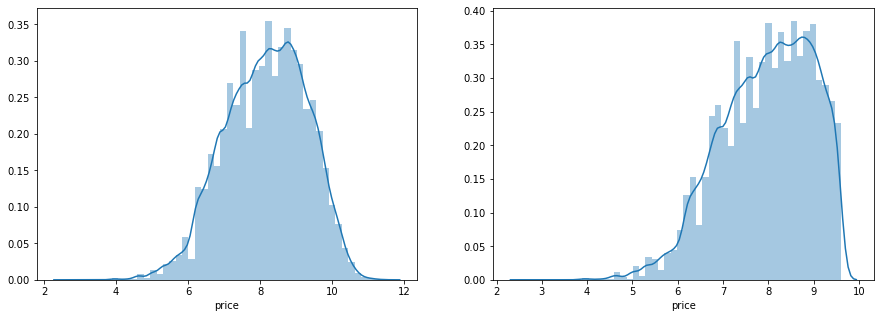

In [16]:
import seaborn as sns
# print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.distplot(train_y_log)

plt.subplot(1,2,2)
sns.distplot(train_y_log[train_y_log < np.quantile(train_y_log, 0.9)])

In [17]:
start = time.time()
model = model.fit(train_X, train_y_log)
end = time.time()
print('总共用时 %.2fs' % (end - start) )

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_features, model.coef_)).items(), key=lambda x: x[1], reverse=True)

总共用时 0.20s
intercept:18.750745460095338


[('v_9', 8.052411927760234),
 ('v_5', 5.7642485022748255),
 ('v_12', 1.6182066744744632),
 ('v_1', 1.4798302934397944),
 ('v_11', 1.1669014496983516),
 ('v_13', 0.9404706038652693),
 ('v_7', 0.7137295307901032),
 ('v_3', 0.6837865320358447),
 ('v_0', 0.008500525238677578),
 ('power_bin', 0.00849796722621272),
 ('gearbox', 0.00792237781994121),
 ('fuelType', 0.006684768278652474),
 ('bodyType', 0.004523520659143269),
 ('power', 0.0007161896117535689),
 ('brand_price_min', 3.334353082748103e-05),
 ('brand_amount', 2.897880010254574e-06),
 ('brand_price_median', 1.2571119996636992e-06),
 ('brand_price_std', 6.659134278570429e-07),
 ('brand_price_max', 6.194957240892153e-07),
 ('brand_price_average', 5.99942948914574e-07),
 ('SaleID', 2.119416206655112e-08),
 ('seller', 1.6653167733693408e-10),
 ('train', -1.8538059975981014e-11),
 ('offerType', -8.43760616930922e-11),
 ('brand_price_sum', -1.5126510445823188e-10),
 ('name', -7.015510649946848e-08),
 ('used_time', -4.122477171057645e-06),


再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况！！

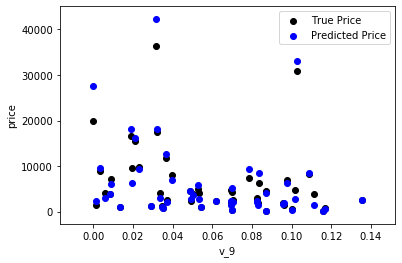

In [18]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
# np.exp 将对数还原
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'], loc='upper right')
# print('The predicted price seems normal after np.log transforming')
plt.show()

#### 2 五折交叉验证

客观的评价模型的训练效果，防止过拟合

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [ ]:
# numpy.nan_to_num(x):
使用0代替数组x中的nan元素，使用有限的数字(float64的最大值)代替inf元素

In [51]:
a = np.array([[np.nan,np.inf], [-np.nan,-np.inf]])
a

array([[ nan,  inf],
       [ nan, -inf]])

In [53]:
b = np.nan_to_num(a)
print(b.dtype)
b

float64


array([[ 0.00000000e+000,  1.79769313e+308],
       [ 0.00000000e+000, -1.79769313e+308]])

In [54]:
np.finfo(np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [20]:
def log_transfer(func):
    def wrapper(y, yhat):
        # func是个评价函数，对这里的预测结果进行对数变换后进行评价
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    # 最后调用的时候 y yhat 是什么，函数内的全部变量？？
    return wrapper

In [ ]:
使用线性回归模型，对未处理标签的特征数据进行五折交叉验证

In [21]:
#  评价器 make_scorer： use in GridSearchCV and cross_val_score，returns a callable that scores an estimator’s output
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


mae的均值

In [22]:
print('AVG:', np.mean(scores))

AVG: 1.3658024042407977


In [ ]:
使用线性回归模型，对处理过标签（取log）的特征数据进行五折交叉验证（Error 0.19）

In [23]:
scores = cross_val_score(model, X=train_X, y=train_y_log, verbose=1, cv=5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


In [24]:
print('AVG:', np.mean(scores))

AVG: 0.19325301535176903


In [25]:
scores

array([0.19079176, 0.19375821, 0.194132  , 0.19182523, 0.19575788])

In [26]:
# 1-d array 也可以转换成 df
pd.DataFrame(scores)

,0
0,0.190792
1,0.193758
2,0.194132
3,0.191825
4,0.195758


In [27]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


#### 3 模拟真实业务情况

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些**与时间相关**的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

In [ ]:
import datetime

In [28]:
data.columns[data.isnull().any()]

Index([], dtype='object')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91729 entries, 0 to 91728
Data columns (total 39 columns):
SaleID                 91729 non-null int32
bodyType               91729 non-null float16
brand                  91729 non-null int8
fuelType               91729 non-null float16
gearbox                91729 non-null float16
kilometer              91729 non-null float16
model                  91729 non-null float16
name                   91729 non-null int32
notRepairedDamage      91729 non-null int8
offerType              91729 non-null int8
power                  91729 non-null int16
price                  91729 non-null float32
seller                 91729 non-null int8
train                  91729 non-null int8
v_0                    91729 non-null float16
v_1                    91729 non-null float16
v_10                   91729 non-null float16
v_11                   91729 non-null float16
v_12                   91729 non-null float16
v_13                   91729 non-null 

In [30]:
data.index

RangeIndex(start=0, stop=91729, step=1)

In [33]:
data.columns

Index(['SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox', 'kilometer',
       'model', 'name', 'notRepairedDamage', 'offerType', 'power', 'price',
       'seller', 'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14',
       'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'used_time',
       'city', 'brand_amount', 'brand_price_max', 'brand_price_median',
       'brand_price_min', 'brand_price_sum', 'brand_price_std',
       'brand_price_average', 'power_bin'],
      dtype='object')

In [31]:
data.reset_index().index

RangeIndex(start=0, stop=91729, step=1)

In [32]:
data.reset_index().columns

Index(['index', 'SaleID', 'bodyType', 'brand', 'fuelType', 'gearbox',
       'kilometer', 'model', 'name', 'notRepairedDamage', 'offerType', 'power',
       'price', 'seller', 'train', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
       'used_time', 'city', 'brand_amount', 'brand_price_max',
       'brand_price_median', 'brand_price_min', 'brand_price_sum',
       'brand_price_std', 'brand_price_average', 'power_bin'],
      dtype='object')

In [34]:
# reset_index()可以还原索引，重新变为默认的整型索引; drop为False则原来的索引列会被还原为普通列放在开头，为True则会被丢失
# data = data.reset_index(drop=True) 没有必要，本来的索引就是整型
# 分隔点
split_point = len(data) // 5 * 4

In [ ]:
# DataFrame可以通过set_index方法，可以设置单索引和复合索引。
DataFrame.set_index(keys, drop=True, append=False, inplace=False, verify_integrity=False) 

In [35]:
# 前面已经删除过缺失值了
train = data.loc[:split_point]
val = data.loc[split_point:]

train_X = train[continuous_features]
train_y_log = np.log(train['price'] + 1)
val_X = val[continuous_features]
val_y_log = np.log(val['price'] + 1)

In [38]:
start = time.time()
model = model.fit(train_X, train_y_log)
end = time.time()
print('%.2f s' % (end - start))

0.15 s


按照时间划分后，预测性能无太大变化，所以得出按照时间划分意义不大！！

In [39]:
# 预测出来的结果就是对数形式的
mean_absolute_error(val_y_log, model.predict(val_X))

0.19577667040507357

#### 4 绘制学习率曲线与验证曲线
学习率曲线验证样本数量与学习性能之间的关系，但是**没有按照时间划分**

In [60]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_size=np.linspace(0.1, 1.0, 4)):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:
        # 参数以元组形式被接受
        plt.ylim(*ylim)  
    plt.xlabel('numbers of Training example')  
    plt.ylabel('score')  
    # learning_curve函数默认的 cv 是五折
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, 
                                                            scoring = make_scorer(mean_absolute_error)) 
    print(train_scores)
    print(test_scores)
    # 返回的结果都是 2-d array，shape (n_ticks, n_cv_folds)，每行是某个train_size下所有cv的scores
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    
    # 生成网格,先再画两条线，再填充
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score") 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")     
    plt.plot(train_sizes, test_scores_mean,'o-',color="g", label="Cross-validation score")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.legend(loc="best")  
    return plt  

[[0.13947291 0.14438067 0.14438067 0.14438067 0.14438067]
 [0.16756154 0.16932819 0.1673073  0.1673073  0.1673073 ]
 [0.18848625 0.18998177 0.17464052 0.1746184  0.1746184 ]
 [0.18169766 0.18309088 0.1738922  0.18115452 0.18187982]]
[[0.38559427 0.76583317 1.40242331 1.86605121 2.48258257]
 [0.20900804 0.19114955 0.2254299  0.205848   0.21533467]
 [0.19990851 0.18311713 0.21211396 0.19585196 0.18742677]
 [0.18776207 0.18088496 0.20557873 0.19440749 0.18472851]]


<module 'matplotlib.pyplot' from 'd:\\softwares\\anaconda\\envs\\tf\\lib\\site-packages\\matplotlib\\pyplot.py'>

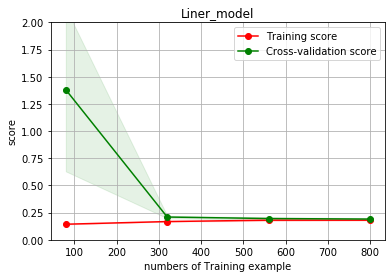

In [61]:
# 我的测试集的结果比较不稳定
plot_learning_curve(LinearRegression(normalize=True), 'Liner_model', train_X[:1000], train_y_log[:1000], ylim=(0.0, 2), cv=5, n_jobs=1)  

验证曲线验证不同的参数取值与学习性能之间的关系

### 二、多种模型对比
**没有按照时间划分**

In [63]:
train_X = data[continuous_features]
train_y = data['price']
train_y_log = np.log(train_y + 1)

#### 1 线性模型 & 嵌入式特征选择
默认已经了解过拟合、模型复杂度、正则化等概念

在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程明显分开。而嵌入式特征选择在学习器训练过程中自动地进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归与Lasso回归。

In [64]:
from sklearn.linear_model import Ridge, Lasso

In [79]:
models = [LinearRegression(),
          LinearRegression(normalize=True),
          Ridge(),
          Lasso()]

In [84]:
for i, model in enumerate(models):
    print(str(model), '\t', str(model).split('(')[0] + str(i))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 	 LinearRegression0
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True) 	 LinearRegression1
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) 	 Ridge2
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) 	 Lasso3


In [86]:
result = dict()
for i, model in enumerate(models):
    model_name = str(model).split('(')[0] + str(i)
    start = time.time()
    # 每个模型做5折交叉验证
    scores = cross_val_score(model, X=train_X, y=train_y_log, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    # scores是验证集的score，是 1-d array，shape=(cv, )
    # 相同的键值只能有一个，取第二次的
    result[model_name] = scores
    end = time.time()
    # 格式化输出，必须加 :
    print('{} is finished，用时{:.2f}s'.format(model_name, (end-start)))

LinearRegression0 is finished，用时0.82s
LinearRegression1 is finished，用时0.84s
Ridge2 is finished，用时0.45s
Lasso3 is finished，用时11.36s


四种模型的结果对比

In [87]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression0,LinearRegression1,Ridge2,Lasso3
cv1,0.190792,0.190792,0.194832,0.383899
cv2,0.193758,0.193758,0.197632,0.381893
cv3,0.194132,0.194132,0.198123,0.384090
cv4,0.191825,0.191825,0.195670,0.380526
cv5,0.195758,0.195758,0.199676,0.383611


画出每个特征的重要性大小

intercept:18.750745393780893


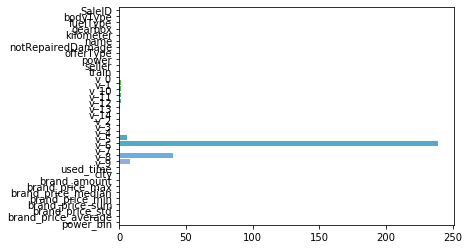

In [88]:
model = LinearRegression().fit(train_X, train_y_log)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_features)

normalize只是加入L2正则化（**但是又不等价于ridge，为何？？**），如果想要数据标准化(standardize), 使用sklearn.preprocessing.StandardScaler

intercept:18.750745460095338


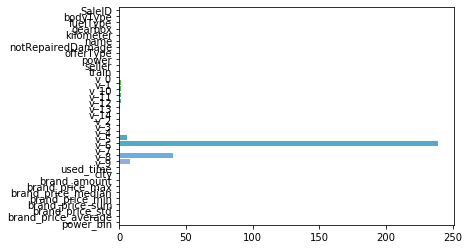

In [90]:
model = LinearRegression(normalize=True).fit(train_X, train_y_log)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_features)

L2正则化在拟合过程中倾向于构造一个所有参数都比较小、比较简单的模型，增强泛化性能，一定程度上避免过拟合。  
可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是**抗扰动能力强**

intercept:4.67171085713669


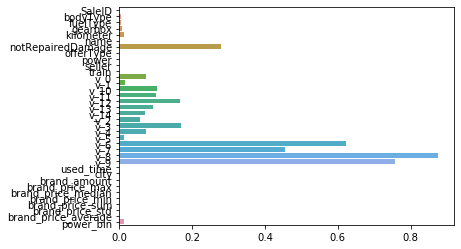

In [91]:
model = Ridge().fit(train_X, train_y_log)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_features)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现**power与userd_time特征**非常重要

intercept:8.672182395725445


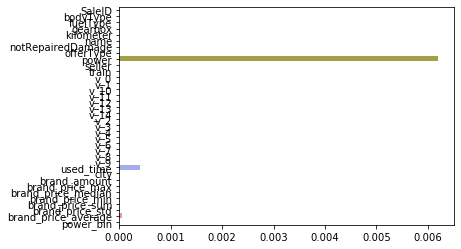

In [92]:
model = Lasso().fit(train_X, train_y_log)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_features)

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，**优先选择的分裂特征更比其他特征更重要**，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的

#### 2 非线性模型

选择部分常用模型与线性模型进行效果比对

In [93]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [94]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

**MLP ???**

In [95]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    start = time.time()
    # 每个模型做5折交叉验证
    scores = cross_val_score(model, X=train_X, y=train_y_log, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
    # scores是验证集的score，是 1-d array，shape=(cv, )
    result[model_name] = scores
    end = time.time()
    # 格式化输出，必须加 :
    print('{} is finished，用时{:.2f}s'.format(model_name, (end-start)))

LinearRegression is finished，用时0.84s
DecisionTreeRegressor is finished，用时15.21s
RandomForestRegressor is finished，用时56.60s
GradientBoostingRegressor is finished，用时51.20s
MLPRegressor is finished，用时146.41s
XGBRegressor is finished，用时52.32s
LGBMRegressor is finished，用时8.81s


In [96]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.198361,0.141340,0.168902,507.319356,0.169990,0.141546
cv2,0.193758,0.192586,0.142059,0.171846,1585.998402,0.171826,0.145501
cv3,0.194132,0.190343,0.142343,0.170935,259.742027,0.172115,0.143887
cv4,0.191825,0.189803,0.141676,0.169083,502.157617,0.169635,0.142497
cv5,0.195758,0.204340,0.146941,0.174094,1120.167496,0.172824,0.144852


In [117]:
result.mean(axis=0)

LinearRegression               0.193253
DecisionTreeRegressor          0.195087
RandomForestRegressor          0.142872
GradientBoostingRegressor      0.170972
MLPRegressor                 795.076980
XGBRegressor                   0.171278
LGBMRegressor                  0.143656
dtype: float64

可以看到随机森林模型在几乎每一个fold中均取得了最好的效果，lgb的效果也不错

### 三、模型调参

三种常用的调参方法：贪心算法、网格调参、贝叶斯调参，为了防止过拟合，评价的是测试基的数据

只调了lgb模型

#### 1 贪心调参法

In [100]:
objective = ['regression', 'regression_l1']
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_log, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
best_obj

{'regression': 0.1436564294510974, 'regression_l1': 0.142368724430397}

In [104]:
help(min)

Help on built-in function min in module builtins:

min(...)
    min(iterable, *[, default=obj, key=func]) -> value
    min(arg1, arg2, *args, *[, key=func]) -> value
    
    With a single iterable argument, return its smallest item. The
    default keyword-only argument specifies an object to return if
    the provided iterable is empty.
    With two or more arguments, return the smallest argument.



In [108]:
# 判断对象是否iterable
hasattr(best_obj.items(), '__iter__')

True

In [105]:
best_obj.items()

dict_items([('regression', 0.1436564294510974), ('regression_l1', 0.142368724430397)])

In [107]:
dir(best_obj.items())

['__and__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__rand__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__ror__',
 '__rsub__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__xor__',
 'isdisjoint']

In [111]:
# 不list话是个map对象，无法显示
list( map(lambda x: x[1], 
          best_obj.items()
         ) 
    )

[0.1436564294510974, 0.142368724430397]

In [112]:
# min操作基于键值，返回的居然是一个元组（键值对）
min(best_obj.items(), key=lambda x: x[1]),      min(best_obj.items(), key=lambda x:x[1])[0]

(('regression_l1', 0.142368724430397), 'regression_l1')

In [114]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']
num_leaves = [3, 5, 10, 15, 20, 40, 55]
max_depth = [3, 5, 10, 15, 20, 40, 55]

bagging_fraction = []
feature_fraction = []
drop_rate = []

In [116]:
start = time.time()

best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_log, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score

# 基于前一个参数的训练结果，减少一个参数的调参
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor( objective=min(best_obj.items(), key=lambda x:x[1])[0], 
                           num_leaves=leaves
                         )
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_log, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score

# 基于前两个参数的训练结果，再减少一个参数
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor( objective=min(best_obj.items(), key=lambda x:x[1])[0],
                           num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                           max_depth=depth
                         )
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_log, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score
    
end = time.time()
print( '总共用时{:.2f}s'.format(end-start) )

总共用时205.74s


In [128]:
best_obj

{'regression': 0.1436564294510974,
 'regression_l1': 0.142368724430397,
 'mape': 0.14311170224329464,
 'huber': 0.1428921310864728,
 'fair': 0.1438883269488307}

In [118]:
best_obj.values()

dict_values([0.1436564294510974, 0.142368724430397, 0.14311170224329464, 0.1428921310864728, 0.1438883269488307])

In [121]:
min(best_obj.values()),  min(best_leaves.values()),  min(best_depth.values())

(0.142368724430397, 0.13577653955350616, 0.13566813132724945)

In [129]:
best_leaves

{3: 0.19795713701063877,
 5: 0.1795665266198841,
 10: 0.16034687276450824,
 15: 0.15286509538958012,
 20: 0.14816575343743882,
 40: 0.13901684374352344,
 55: 0.13577653955350616}

In [130]:
best_depth

{3: 0.17451384688415622,
 5: 0.14939265226818377,
 10: 0.13586880539437227,
 15: 0.1357364478379169,
 20: 0.13566813132724945,
 40: 0.13577653955350616,
 55: 0.13577653955350616}

绘制出每次调参，模型的性能提升情况

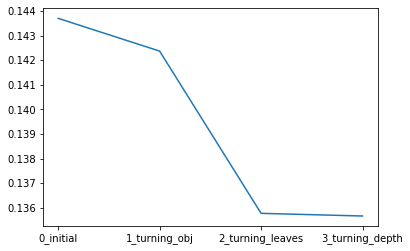

In [119]:
sns.lineplot(x=['0_initial', '1_turning_obj', '2_turning_leaves', '3_turning_depth'], 
             y=[0.1437, min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

#### 2 Grid Search 调参

In [122]:
from sklearn.model_selection import GridSearchCV

In [131]:
n_estimators = [100, 150, 200]
objective = ['regression_l1']
num_leaves = [50, 55, 60]
max_depth = [20, 25, 30]

In [ ]:
lgb模型默认的 n_jobs是-1（100%），在GridSearchCV定义 n_jobs 不起作用

In [132]:
start = time.time()
parameters = {'n_estimators':n_estimators, 
              'objective': objective , 
              'num_leaves': num_leaves, 
              'max_depth': max_depth
             }
model = LGBMRegressor()
# 不知道这里的 n_jobs 起不起作用
clf = GridSearchCV(model, parameters, scoring=make_scorer(mean_absolute_error), cv=5)
clf = clf.fit(train_X, train_y_log)
end = time.time()
print( '总共用时{:.2f}s'.format(end-start) )

总共用时168.10s


In [135]:
clf.cv_results_

{'mean_fit_time': array([2.32585497, 2.44045367, 2.54036064, 3.26411057, 3.55942612,
        3.56473098, 4.11554646, 4.46728926, 4.65978041, 2.42252922,
        2.47114773, 2.52264667, 3.29437075, 3.41880646, 3.62402821,
        4.04129086, 4.22709899, 4.33936291, 2.2330205 , 2.35596399,
        2.42485805, 3.02366786, 3.21585641, 3.35781503, 3.80311403,
        3.97584844, 3.9883152 ]),
 'std_fit_time': array([0.06123379, 0.05860776, 0.04307096, 0.10957687, 0.06161789,
        0.05160574, 0.07307439, 0.07782605, 0.10135362, 0.08898036,
        0.06077168, 0.06025996, 0.05491556, 0.08152484, 0.03094378,
        0.06052054, 0.05973649, 0.13089978, 0.04656868, 0.01456701,
        0.04396122, 0.07433575, 0.05990913, 0.06901617, 0.04247831,
        0.06200023, 0.50106603]),
 'mean_score_time': array([0.15933604, 0.16246305, 0.17495766, 0.22000074, 0.22450738,
        0.22496891, 0.26075158, 0.27505274, 0.27603364, 0.16292758,
        0.1645649 , 0.16405158, 0.21482658, 0.22102718, 0.221279

In [142]:
len(clf.cv_results_['params'])

27

根据数值在list里找index，只返回第一个找到的

In [140]:
# 有两个模型参数组合的 mae 最小，均为610.670054
clf.cv_results_['mean_test_score']

array([675.69559914, 669.92266967, 664.21490495, 641.73975167,
       635.3264017 , 630.6447903 , 620.74022884, 615.38751512,
       612.52667048, 676.10108008, 669.64058212, 663.078914  ,
       640.49211482, 634.51278121, 628.83856263, 620.01879801,
       615.72531748, 610.670054  , 676.10108008, 669.64058212,
       663.078914  , 640.49211482, 634.51278121, 628.83856263,
       620.01879801, 615.72531748, 610.670054  ])

In [146]:
min(clf.cv_results_['mean_test_score']), clf.cv_results_['mean_test_score'].tolist().index(min(clf.cv_results_['mean_test_score']))

(610.6700539983888, 17)

In [147]:
clf.cv_results_['params'][17]

{'max_depth': 25,
 'n_estimators': 200,
 'num_leaves': 60,
 'objective': 'regression_l1'}

In [149]:
clf.cv_results_['params'][26]

{'max_depth': 30,
 'n_estimators': 200,
 'num_leaves': 60,
 'objective': 'regression_l1'}

这个 best_score_是错误的，找了个最大的。。。，那best_model估计也是错误的。。。

In [136]:
clf.best_score_

676.1010800838436

In [138]:
clf.best_index_

9

In [139]:
clf.scorer_

make_scorer(mean_absolute_error)

In [133]:
clf.best_params_

{'max_depth': 25,
 'n_estimators': 100,
 'num_leaves': 50,
 'objective': 'regression_l1'}

In [134]:
clf.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=25,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=50,
              objective='regression_l1', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

**取对数后，mae一下降低超多，跟原始mae取对数的结果不一致，为何？？**  
用预测目标的对数进行训练，这回只是基本频率2.39HZ，没有睿频，上回是睿频3.8HZ，跑了一会又开始睿频了 
如果lgb默认参数n_jobs=-1的话，有时候只跑一个cpu，基本频率，为何？？

In [150]:
n_estimators = [175, 200, 225, 250]
objective = ['regression_l1']
num_leaves = [60, 65, 70]
max_depth = [20, 25, 30]

In [153]:
start = time.time()
parameters = {'n_estimators':n_estimators, 
              'objective': objective , 
              'num_leaves': num_leaves, 
              'max_depth': max_depth
             }
model = LGBMRegressor(n_jobs=6)
reg = GridSearchCV(model, parameters, scoring=make_scorer(mean_absolute_error), cv=5)
reg.fit(train_X, train_y_log)
end = time.time()
print( '总共用时{:.2f}s'.format(end-start) )

总共用时479.91s


In [155]:
reg.cv_results_[ 'mean_test_score']

array([0.12861281, 0.12799328, 0.12784098, 0.12757689, 0.127013  ,
       0.12690815, 0.12672781, 0.12631516, 0.1261875 , 0.12606122,
       0.12570157, 0.12554502, 0.12855501, 0.12831058, 0.12772191,
       0.1275108 , 0.12725201, 0.12677471, 0.12667792, 0.12656929,
       0.12601923, 0.12606142, 0.1259461 , 0.12540809, 0.12855501,
       0.12829592, 0.12772191, 0.1275108 , 0.12719124, 0.12677471,
       0.12667792, 0.12650499, 0.12601923, 0.12606142, 0.12587803,
       0.12540809])

In [165]:
min(reg.cv_results_[ 'mean_test_score']),  max(reg.cv_results_[ 'mean_test_score'])

(0.1254080873193092, 0.12861280806066597)

In [168]:
reg.cv_results_[ 'mean_test_score'].tolist().index(min(reg.cv_results_[ 'mean_test_score']))

23

In [171]:
reg.cv_results_['params'][23]

{'max_depth': 25,
 'n_estimators': 250,
 'num_leaves': 70,
 'objective': 'regression_l1'}

In [163]:
reg.best_index_

0

In [157]:
reg.best_score_

0.12861280806066597

In [158]:
reg.best_params_

{'max_depth': 20,
 'n_estimators': 175,
 'num_leaves': 60,
 'objective': 'regression_l1'}

In [159]:
reg.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=20,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=175, n_jobs=6, num_leaves=60,
              objective='regression_l1', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [161]:
reg.scorer_

make_scorer(mean_absolute_error)

根据mae最小化原则找到的最佳参数，线下最佳 594 分

In [172]:
best_model = LGBMRegressor(max_depth=25, 
                           n_estimators=250, 
                           num_leaves=70, 
                           objective='regression_l1', 
                           n_jobs=4)
reg_scores_log = cross_val_score(best_model, X=train_X, y=train_y_log, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))
reg_scores = cross_val_score(best_model, X=train_X, y=train_y, verbose=0, cv=5, scoring=make_scorer(mean_absolute_error))

In [173]:
reg_scores_log.mean()

0.12540810340953376

In [174]:
reg_scores.mean()

594.5231406742474

#### 3 贝叶斯调参
pip install bayesian_optimization  
https://www.cnblogs.com/chenxiangzhen/p/10636896.html

In [176]:
from bayes_opt import BayesianOptimization

由于BayesianOptimization的属性限制，所以在这里返回 1-val，最后再减去  
lgb 对除 subsample 外的**参数的要求确实是 int**   

**lgb的参数对应的参数值是 bayes_opt 选择的参数组合提供的，为了明晰这一点，将传入的参数值加上后缀 _value**  
n_jobs=3，  3 / 8 = 0.375 cpu38%，2.4HZ，过一会

In [205]:
def rf_cv(n_estimators_value, num_leaves_value, max_depth_value, subsample_value, min_child_samples_value):
    """
    lgb的参数是baye_opt传过来的！！，所以定义函数的时候参数一定要包括lgb参数对应的参数值，
    否则报错：TypeError: rf_cv() got an unexpected keyword argument 'n_estimators'
    """
    val_scores = cross_val_score(
        LGBMRegressor(objective='regression_l1',                         # 字符型参数，无法通过贝叶斯调参法进行优化
                      n_estimators=int(n_estimators_value),                      
                      num_leaves=int(num_leaves_value),
                      max_depth=int(max_depth_value),
                      subsample = subsample_value,                       # Subsample ratio of the training instance.
                      min_child_samples = int(min_child_samples_value),  # Minimum number of data needed in a child (leaf).
                      n_jobs=3
                      ),
        X=train_X, 
        y=train_y_log, 
        verbose=0, 
        cv=5, 
        scoring=make_scorer(mean_absolute_error)
    )
    return val_scores.mean()

给出各个参数的优化目标范围，应该不是遍历，否则时间太长  
BayesianOpt 对参数 pbounds 会自动取成浮点数，但是lgb那里会把需要的转成int，以符合模型要求！！  
BayesianOpt **对参数 pbounds** 的数据类型有限制，必须是数值型的、可以被转化为float的，int或float都可以，但不能是字符型的：ValueError: could not convert string to float: 'regression'  
对参数的个数有什么限制，超过多少个后训练速度会明显变慢？？

In [206]:
rf_bayes_opt = BayesianOptimization(
    f = rf_cv,    
    pbounds = {'n_estimators_value':(100, 300), 
               'num_leaves_value': (2, 100), 
               'max_depth_value': (2, 100), 
               'subsample_value': (0.1, 1), 
               'min_child_samples_value': (2, 100)
              }
)

可以多迭代几次（默认是30次），迭代次数越多越有可能通过贝叶斯优化找到一个更好的结果, 再加上10次随机优化 
https://github.com/fmfn/BayesianOptimization

In [207]:
start = time.time()
rf_bayes_opt.maximize(init_points=10, # Random exploration steps, can help by diversifying the exploration space.
                      n_iter=50       # steps of bayesian optimization, The more steps the more likely to find a good maximum you are.
                     )
end = time.time()
print( '总共用时{:.2f}s'.format(end-start) )

|   iter    |  target   | max_de... | min_ch... | n_esti... | num_le... | subsam... |
-------------------------------------------------------------------------------------
|  1        |  0.1318   |  23.75    |  13.56    |  129.8    |  59.96    |  0.5077   |
|  2        |  0.1575   |  55.95    |  46.01    |  164.4    |  7.058    |  0.4956   |
|  3        |  0.1275   |  10.64    |  96.28    |  189.5    |  68.35    |  0.4997   |
|  4        |  0.1277   |  15.04    |  31.39    |  154.1    |  80.24    |  0.1483   |
|  5        |  0.1284   |  92.93    |  20.89    |  155.2    |  74.96    |  0.7859   |
|  6        |  0.1356   |  57.72    |  11.38    |  144.8    |  35.03    |  0.4403   |
|  7        |  0.1246   |  96.14    |  9.262    |  244.3    |  95.39    |  0.5431   |
|  8        |  0.1284   |  79.27    |  26.21    |  204.5    |  53.3     |  0.4304   |
|  9        |  0.126    |  67.83    |  18.06    |  259.7    |  61.95    |  0.8808   |
|  10       |  0.1268   |  29.55    |  56.89    |  156

|  58       |  0.2281   |  44.21    |  89.29    |  100.2    |  2.653    |  0.6757   |
|  59       |  0.1831   |  39.75    |  98.44    |  191.6    |  3.53     |  0.4461   |
|  60       |  0.202    |  98.4     |  2.812    |  220.8    |  2.173    |  0.7481   |
总共用时428.69s


官方说明：The best combination of parameters and target value found can be accessed via the property optimizer.max.  
所以用的是 1-mae，最后找到最大的1-mae就是最小的mae

In [208]:
rf_bayes_opt.max

{'target': 0.22809648599197802,
 'params': {'max_depth_value': 2.222159226701153,
  'min_child_samples_value': 3.709496902418164,
  'n_estimators_value': 100.3511302840505,
  'num_leaves_value': 2.82230563956145,
  'subsample_value': 0.732594158488113}}

**最小的，41次，mae = 0.1231，但是感觉各个参数都很极端，容易过拟合，比如subsample太小，max_depth、min_child_samples_value、n_estimators_value都极大**

In [186]:
# not iterable
rf_bayes_opt

TypeError: 'BayesianOptimization' object is not iterable